# Physics-Informed Autoencoders for Virtual Pathology of Prostate

In [31]:
from utils import get_batch, hybrid_fit, ADC_slice
import time
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from PIA import PIA
import torch
import copy
import os
import mat73
import scipy.io as sio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from PIA import  density_scatter
# 
# 
# 
# from IPython.display import clear_output


# import collections

# 
# from IPython import display
# 

## Testing the 3-Compartment Model on random set of 2500 samples

In [ ]:
test, D_test2, T2_test2, v_test2, _ = get_batch(2500, noise_sdt=0.05)
test = test.detach().cpu().numpy()
start = time.time()
D, T2, v = hybrid_fit(test)
end = time.time()
print(f'Hybrid 1.0 takes {end - start} seconds')

## Lets plot the distributions

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    for c in range(3):
        if r==0:
            x_image, y_image = v_test2, v
            title = ['V_ep', 'V st', 'V lu']
            ylims = [(0,1), (0,1), (0,1)]
        elif r==1:
            x_image, y_image = D_test2, D
            title = ['D ep', 'D st', 'D lu']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]
        elif r==2:
            x_image, y_image = T2_test2, T2
            title = ['T2 ep', 'T2 st', 'T2 lu']
            ylims = [(20, 70), (40, 100), (500, 1000)]
        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c]
        nbins=300
        k = gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax[r,c].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="hot", shading='auto')
        ax[r,c].scatter(x, y, s=0.3, color="white", alpha=0.7)

        err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image[:, c]))
        corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image[:, c])[0,1]

        ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
        ax[r,c].set_xlabel('true', fontsize=20)
        ax[r,c].set_ylabel('predicted', fontsize=20)

## Train PIA with Additive Gaussian Noise

In [ ]:
# The code below assumes you have a GPU - but I will fix it in a later push
model =  PIA(predictor_depth=2)
params = list(model.encoder.parameters()) + list(model.v_predictor.parameters()) + list(model.D_predictor.parameters()) + list(model.T2_predictor.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

ctr = 1
total_loss = 0 

for ep in range(50000):
    x, D_true, T2_true, v_true, y = get_batch(128)
    x , y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    D, T2, v = model.encode(x)        
    recon = model.decode(D, T2, v).cuda()
    PIDS = torch.from_numpy(np.ones((128, 16))).cuda()
    loss = model.loss_function(recon, y, PIDS, tissue_available=False)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    print(f'{total_loss/ctr}',end ="\r")
    ctr += 1
PATH = 'pia_model2.pt'
torch.save(model, PATH)


## Test PIA on the same set of 2500 test samples

In [22]:
PATH = 'pia_model.pt'
model = torch.load(PATH)

In [23]:
start = time.time()
test = torch.from_numpy(test).cuda()
D, T2, v = model.encode(test)
end = time.time()
print(f'PIA takes {end - start} seconds')

PIA takes 0.00792074203491211 seconds


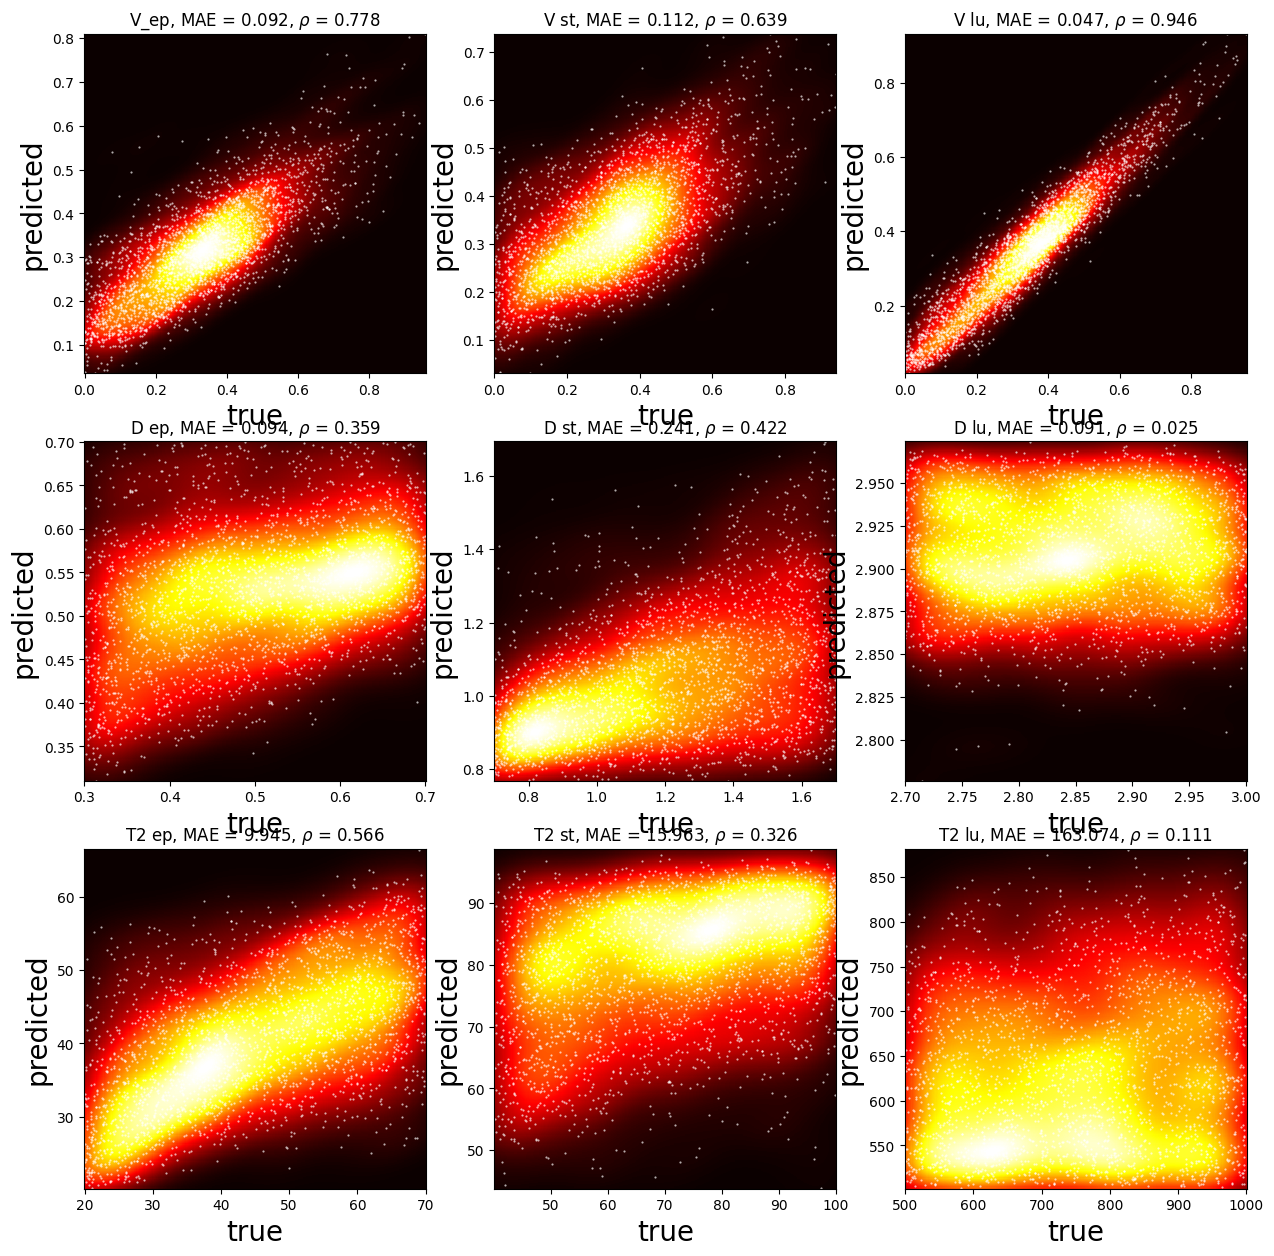

In [24]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    for c in range(3):
        if r==0:
            x_image, y_image = v_test2, v
            title = ['V_ep', 'V st', 'V lu']
            ylims = [(0,1), (0,1), (0,1)]
        elif r==1:
            x_image, y_image = D_test2, D
            title = ['D ep', 'D st', 'D lu']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]
        elif r==2:
            x_image, y_image = T2_test2, T2
            title = ['T2 ep', 'T2 st', 'T2 lu']
            ylims = [(20, 70), (40, 100), (500, 1000)]
        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image.detach().cpu().numpy()[:, c]
        nbins=300
        k = gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax[r,c].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="hot", shading='auto')
        ax[r,c].scatter(x, y, s=0.3, color="white", alpha=0.7)

        err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image.detach().cpu().numpy()[:, c]))
        corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image.detach().cpu().numpy()[:, c])[0,1]

        ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
        ax[r,c].set_xlabel('true', fontsize=20)
        ax[r,c].set_ylabel('predicted', fontsize=20)

In [28]:

BASE_ADDRESS = 'sample_anon_data'
data_address = os.path.join(BASE_ADDRESS, 'pat026_hybridSortedInput.mat')
print('Loading data')

try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address) 
print('Data loaded')


b_values = data['b']
TE_values = data['TE']
TE_norm = data['TE_norm']
hybrid_data = data['hybrid_data']


hybrid_raw_reshaped = hybrid_data.copy()
hybrid_normalized = np.zeros_like(hybrid_raw_reshaped)

for b in range(4):
    for te in range(4):
        hybrid_normalized[:, :, :, b, te] = 1000*hybrid_raw_reshaped[:, :, :, b, te]/(hybrid_raw_reshaped[:, :, :, 0, 0] + 1e-7)

Loading data
Data loaded


In [29]:
_slice = 10
_from = 35
_to = 95

hybrid_data2 = np.reshape(hybrid_normalized, (128, 128, hybrid_data.shape[2], 16))
model_input = np.squeeze(hybrid_data2[_from: _to, _from: _to, _slice, :])
bins = (model_input.shape[0], model_input.shape[1])
model_input = np.reshape(model_input, (model_input.shape[0]*model_input.shape[1], 16))

### In-vivo tests with PIA 

PIA took 0.03141951560974121 seconds


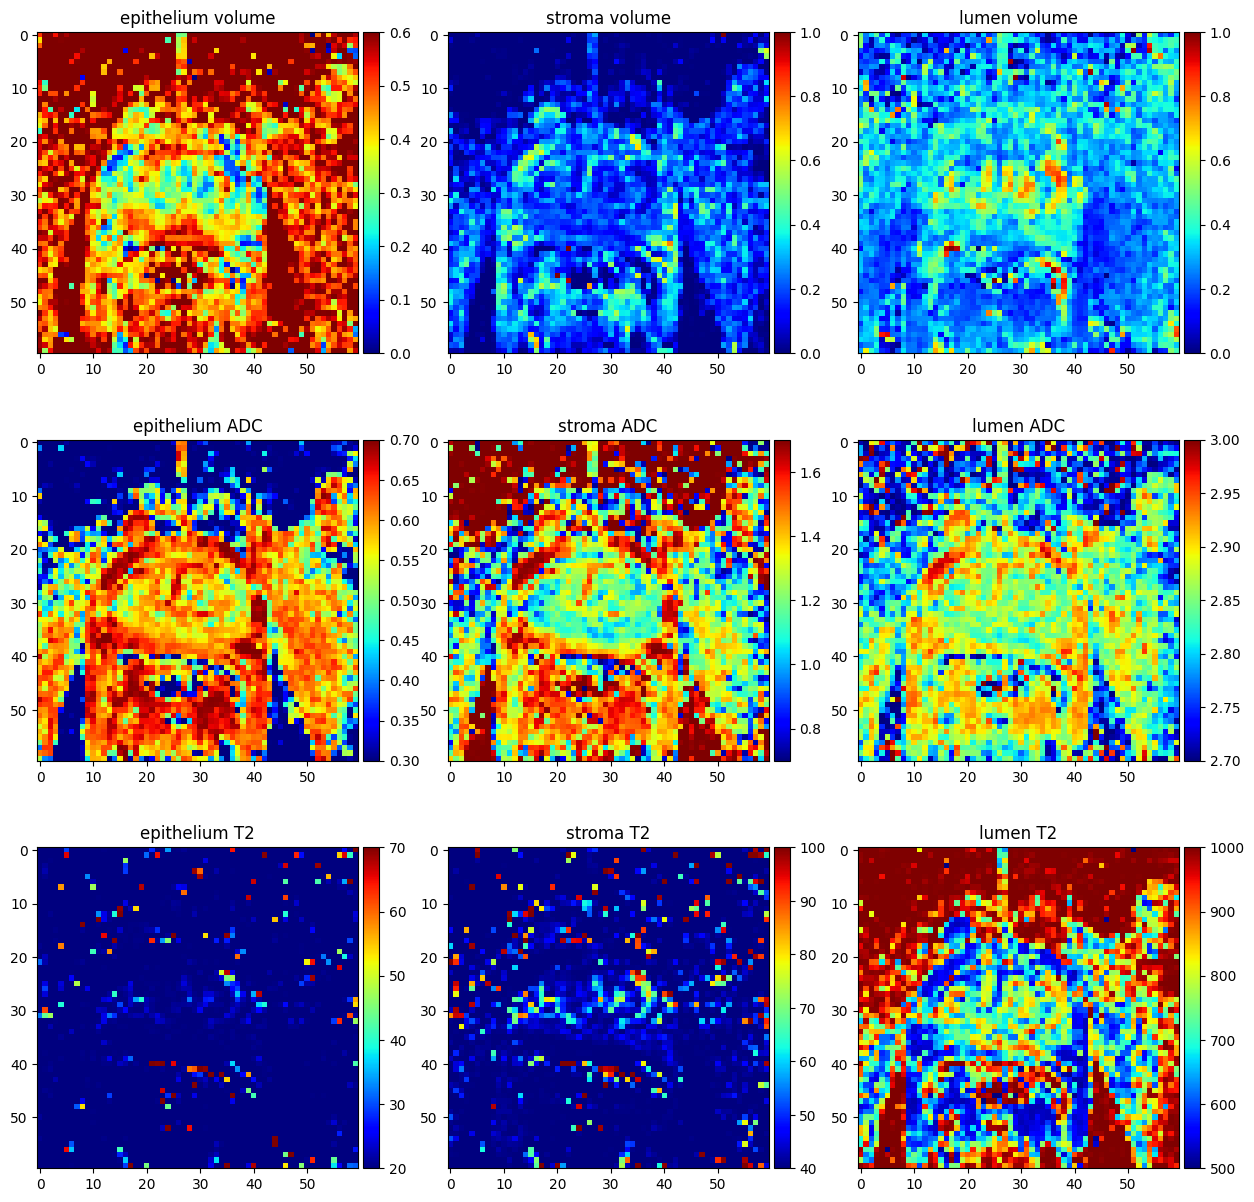

In [32]:
PATH = 'pia_model.pt'
model = torch.load(PATH)


model_input_tensor = torch.from_numpy(model_input)
model_input_tensor = model_input_tensor.float().cuda()
start = time.time()
D, T2, v = model.encode(model_input_tensor)
end = time.time()
print(f'PIA took {end - start} seconds')
error = {}

fig, ax = plt.subplots(3,3, figsize=(15,15))

for r in range(3):
    for c in range(3):
        if r==0:
            x_image = v
            title = ['epithelium volume', 'stroma volume', 'lumen volume']
            ylims = [(0,0.6), (0,1), (0,1)]
        elif r==1:
            x_image = D
            title = ['epithelium ADC', 'stroma ADC', 'lumen ADC']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]

        else:
            x_image =  T2
            title = ['epithelium T2', 'stroma T2', 'lumen T2']
            ylims = [(20, 70), (40, 100), (500, 1000)]
        img = np.reshape(x_image[:,c].detach().cpu().numpy(), bins)
        im = ax[r,c].imshow(img, vmin=ylims[c][0], vmax=ylims[c][1],cmap='jet')
        divider = make_axes_locatable(ax[r,c])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax[r,c].set_title(fr'{title[c]}')

v_ep = np.reshape(v[:,0].detach().cpu().numpy(), bins) 
v_lu = np.reshape(v[:,2].detach().cpu().numpy(), bins)
D_ep = np.reshape(D[:,0].detach().cpu().numpy(), bins) 
T2_ep = np.reshape(T2[:,0].detach().cpu().numpy(), bins) 



In [ ]:
v_ep = np.reshape(v[:,0].detach().cpu().numpy(), bins) 
v_lu = np.reshape(v[:,2].detach().cpu().numpy(), bins)
D_ep = np.reshape(D[:,0].detach().cpu().numpy(), bins) 
T2_ep = np.reshape(T2[:,0].detach().cpu().numpy(), bins) 

cancer_map = (v_ep >= 0.4)*(v_lu <= 0.2)

adc_map = ADC_slice(b_values, np.squeeze(hybrid_data[_from: _to, _from : _to, _slice, :, 0]))


fig, ax = plt.subplots(1, figsize=(6,6))
fig.suptitle('predicted cancer map')
ax.imshow(adc_map, cmap='gray')
cancer_map = morphology.remove_small_objects(cancer_map.astype(bool), min_size=10, connectivity=1)
cancer_map = cancer_map.astype(float)
cancer_map[cancer_map==0] = np.nan
ax.imshow(cancer_map, cmap='autumn',alpha = 0.4)
ax.axis('off')
